Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing** **Skin Cancer Data**

**Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
data_dir_train = pathlib.Path('/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [6]:
image_size = (img_height,img_width)
train_ds = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',      # Automatically infer labels from subdirectory names
    label_mode='int',       # Return integer labels
    image_size=image_size,  # Resize images to 180x180
    batch_size=batch_size,  # Set batch size
    seed=123,                # Set seed for reproducibility
    validation_split=0.2,   # Use 20% of data for validation
    subset="training"       # Load training subset
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation"  # Load validation subset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


**Visualize the data**

visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt


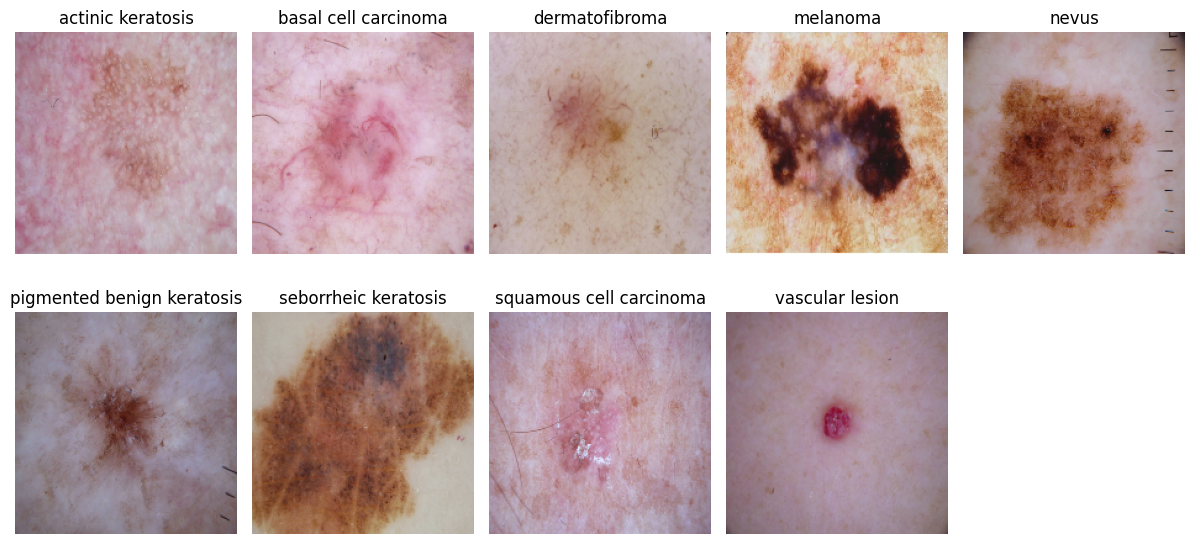

In [ ]:
images_per_class = [None] * num_classes
# Iterate over the dataset
for images, labels in val_ds:
    for i, label in enumerate(labels.numpy()):
        if images_per_class[label] is None:
            images_per_class[label] = images[i].numpy()
        # Break if we've found an image for each class
        if all(img is not None for img in images_per_class):
            break
    if all(img is not None for img in images_per_class):
        break

# Plot the images
plt.figure(figsize=(12, 6))
for idx, image in enumerate(images_per_class):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(val_ds.class_names[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [11]:
val_ds.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [12]:
### Input shape based on element spec above
input_shape = (180, 180, 3)

In [ ]:
#Build the model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
56/56 - 16s - 283ms/step - accuracy: 0.1897 - loss: 2.6231 - val_accuracy: 0.2058 - val_loss: 2.0280
Epoch 2/20
56/56 - 4s - 76ms/step - accuracy: 0.1920 - loss: 2.0369 - val_accuracy: 0.2058 - val_loss: 2.0192
Epoch 3/20
56/56 - 5s - 90ms/step - accuracy: 0.2037 - loss: 2.0248 - val_accuracy: 0.2304 - val_loss: 1.9793
Epoch 4/20
56/56 - 4s - 76ms/step - accuracy: 0.2450 - loss: 1.9735 - val_accuracy: 0.2796 - val_loss: 1.9602
Epoch 5/20
56/56 - 5s - 89ms/step - accuracy: 0.2450 - loss: 1.9618 - val_accuracy: 0.2483 - val_loss: 1.9517
Epoch 6/20
56/56 - 4s - 74ms/step - accuracy: 0.2779 - loss: 1.9100 - val_accuracy: 0.3803 - val_loss: 1.8509
Epoch 7/20
56/56 - 5s - 92ms/step - accuracy: 0.2533 - loss: 2.0001 - val_accuracy: 0.2438 - val_loss: 1.9926
Epoch 8/20
56/56 - 4s - 74ms/step - accuracy: 0.2539 - loss: 1.9262 - val_accuracy: 0.2528 - val_loss: 1.9560
Epoch 9/20
56/56 - 5s - 89ms/step - accuracy: 0.3510 - loss: 1.7615 - val_accuracy: 0.3065 - val_loss: 1.8801
Epoch 10

As per the final epoch we have following results

Training accuracy: 83.09%

Training loss: 0.5900

Validation accuracy: 46.09%

Validation loss: 2.2982

This is a clear case of overfitting. Lets visualize the results

**Visualizing training results**

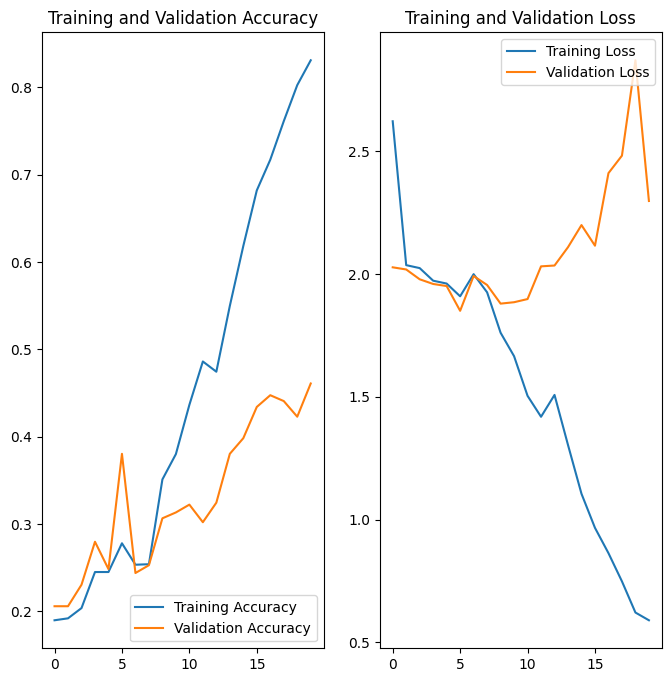

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we see from the above graph, the training accuracy continues to increase with each epoch and there is a corresponding decrease in the training loss. Whereas the validation accuracy increases initially, then it fluctuates around the 50% mark with the final validation accuracy being around 46% as compared to training accuracy of 83%. Thus the model is overfitting the training data

In [13]:
#To solve the overfitting we will use data augmentation. For this we use some available Keras APIs
# RandomFlip: Randomly flips the image horizontally and/or vertically
# RandomRotation: Randomly rotates the image by a specified factor (0.2 means up to 20% of the total range)
# RandomZoom: Randomly zooms into the image

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

**Model with Data Augmentation - Random Flip, Rotation, Zoom**

In [ ]:
#Build the model with data augmentation
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
56/56 - 16s - 278ms/step - accuracy: 0.1775 - loss: 2.8490 - val_accuracy: 0.2416 - val_loss: 2.0187
Epoch 2/20
56/56 - 8s - 134ms/step - accuracy: 0.2059 - loss: 2.0294 - val_accuracy: 0.1991 - val_loss: 2.0186
Epoch 3/20
56/56 - 7s - 132ms/step - accuracy: 0.2472 - loss: 1.9633 - val_accuracy: 0.3221 - val_loss: 1.8640
Epoch 4/20
56/56 - 8s - 136ms/step - accuracy: 0.3158 - loss: 1.8176 - val_accuracy: 0.3893 - val_loss: 1.6907
Epoch 5/20
56/56 - 10s - 176ms/step - accuracy: 0.3717 - loss: 1.7095 - val_accuracy: 0.3736 - val_loss: 1.6106
Epoch 6/20
56/56 - 7s - 128ms/step - accuracy: 0.3817 - loss: 1.6737 - val_accuracy: 0.4027 - val_loss: 1.5804
Epoch 7/20
56/56 - 7s - 128ms/step - accuracy: 0.3878 - loss: 1.6663 - val_accuracy: 0.4519 - val_loss: 1.5692
Epoch 8/20
56/56 - 7s - 128ms/step - accuracy: 0.4152 - loss: 1.6222 - val_accuracy: 0.4385 - val_loss: 1.5561
Epoch 9/20
56/56 - 10s - 183ms/step - accuracy: 0.4157 - loss: 1.6050 - val_accuracy: 0.4832 - val_loss: 1.559

We have below results from the 20th epoch

Training accuracy: 51.95%

Training loss: 1.3636

Validation accuracy: 52.13%

Validation loss: 1.4153

We see a reduction in accuracy, but now the training and validation accuracy are around the same mark of 52%

Lets visualize the data

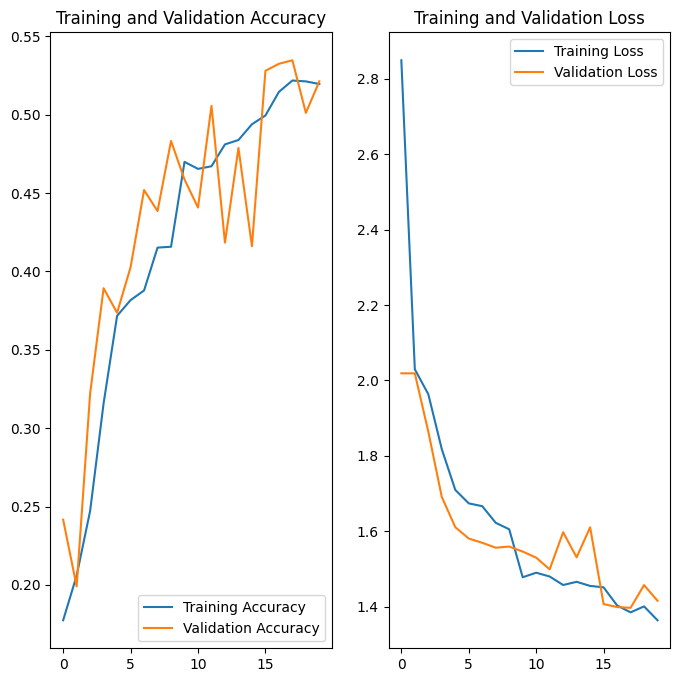

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As seen from the visualization, the training and validation accuracy and loss have a similar trend

**Learning Rate Scheduling**

Lets experiment with a constant learning rate for the first 10 epochs and then reduce it exponentially for subsequent epochs

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Define a simple learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Continue with the same model definition
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_46 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_scheduler],
  verbose=2
)

Epoch 1/20
56/56 - 10s - 175ms/step - accuracy: 0.1920 - loss: 2.7232 - val_accuracy: 0.1678 - val_loss: 2.1267 - learning_rate: 0.0010
Epoch 2/20
56/56 - 7s - 129ms/step - accuracy: 0.2489 - loss: 1.9995 - val_accuracy: 0.3311 - val_loss: 1.8706 - learning_rate: 0.0010
Epoch 3/20
56/56 - 7s - 131ms/step - accuracy: 0.3304 - loss: 1.8578 - val_accuracy: 0.4206 - val_loss: 1.7401 - learning_rate: 0.0010
Epoch 4/20
56/56 - 7s - 131ms/step - accuracy: 0.3884 - loss: 1.6901 - val_accuracy: 0.4139 - val_loss: 1.6068 - learning_rate: 0.0010
Epoch 5/20
56/56 - 10s - 181ms/step - accuracy: 0.3795 - loss: 1.7262 - val_accuracy: 0.4094 - val_loss: 1.6379 - learning_rate: 0.0010
Epoch 6/20
56/56 - 10s - 182ms/step - accuracy: 0.4057 - loss: 1.6295 - val_accuracy: 0.4586 - val_loss: 1.5411 - learning_rate: 0.0010
Epoch 7/20
56/56 - 10s - 181ms/step - accuracy: 0.4185 - loss: 1.6086 - val_accuracy: 0.4116 - val_loss: 1.7292 - learning_rate: 0.0010
Epoch 8/20
56/56 - 7s - 133ms/step - accuracy: 0.43

There is only a slight improvement in the accuracy for training , while there is a decline in the validation accuracy

#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#Training Dataset class counts
class_counts = Counter()

for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Convert to dictionary and print
class_counts = dict(class_counts)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_counts)

{5: 370, 3: 352, 1: 309, 4: 277, 7: 142, 8: 115, 0: 92, 2: 77, 6: 58}


In [ ]:
#Validation Dataset class counts
class_counts = Counter()

for images, labels in val_ds:
    class_counts.update(labels.numpy())

# Convert to dictionary and print
class_counts = dict(class_counts)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_counts)

{5: 92, 3: 86, 4: 80, 1: 67, 7: 39, 8: 24, 0: 22, 6: 19, 2: 18}


#### - Which class has the least number of samples?
In the training data class 6 has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
In both training and test data classes 5 and 3 dominate the data in terms of number of samples
#### Overall we see that there is a class imbalance in the dataset
To work out with this - we will use Augmentor to add more data samples

In [ ]:
!pip install Augmentor

**Adding 500 samples to each class using Augmentor**

In [ ]:
import Augmentor
path_to_training_dataset="/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D3E800AD5A0>: 100%|██████████| 500/500 [00:05<00:00, 99.67 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D3E80101540>: 100%|██████████| 500/500 [00:04<00:00, 112.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3E88048400>: 100%|██████████| 500/500 [00:04<00:00, 106.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D3E80090E20>: 100%|██████████| 500/500 [00:05<00:00, 84.43 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3E800AC5E0>: 100%|██████████| 500/500 [00:06<00:00, 77.60 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3E80079BD0>: 100%|██████████| 500/500 [00:04<00:00, 104.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D3E8005C400>: 100%|██████████| 500/500 [00:05<00:00, 97.99 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3E80078CD0>: 100%|██████████| 500/500 [00:05<00:00, 97.71 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D3E70088400>: 100%|██████████| 500/500 [00:04<00:00, 103.16 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


**Combining the original and augmented data in one directory**

In [ ]:
import os
import shutil

# Define paths
original_data_dir = "/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
augmented_data_dir = "/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
combined_data_dir = "/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Combined/"

# Create the combined data directory
if not os.path.exists(combined_data_dir):
    os.makedirs(combined_data_dir)

# Copy original images to the combined directory
for class_name in class_names:
    original_class_dir = os.path.join(original_data_dir, class_name)
    combined_class_dir = os.path.join(combined_data_dir, class_name)
    if not os.path.exists(combined_class_dir):
        os.makedirs(combined_class_dir)

    for file_name in os.listdir(original_class_dir):
        full_file_name = os.path.join(original_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, combined_class_dir)

# Copy augmented images to the combined directory
for class_name in class_names:
    augmented_class_dir = os.path.join(augmented_data_dir, class_name, 'output')
    combined_class_dir = os.path.join(combined_data_dir, class_name)

    for file_name in os.listdir(augmented_class_dir):
        full_file_name = os.path.join(augmented_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, combined_class_dir)

In [14]:
combined_data_dir_train = pathlib.Path('/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Combined')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_train = len(list(combined_data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239
6739


As we see above, after augmentation, the total image count has increased by 4500 in the train data set

Create the train and validation data set using the combined directory

In [16]:
image_size = (img_height,img_width)
train_ds_aug = image_dataset_from_directory(
    combined_data_dir_train,
    labels='inferred',      # Automatically infer labels from subdirectory names
    label_mode='int',       # Return integer labels
    image_size=image_size,  # Resize images to 180x180
    batch_size=batch_size,  # Set batch size
    seed=123,                # Set seed for reproducibility
    validation_split=0.2,   # Use 20% of data for validation
    subset="training"       # Load training subset
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [17]:
val_ds_aug = image_dataset_from_directory(
    combined_data_dir_train,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation"  # Load validation subset
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Now that we have the train and validation data set after augmentation, lets check the class distribution

In [ ]:
#Training Dataset class counts
class_counts = Counter()

for images, labels in train_ds_aug:
    class_counts.update(labels.numpy())

# Convert to dictionary and print
class_counts = dict(class_counts)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_counts)

{5: 773, 3: 755, 1: 721, 4: 677, 7: 569, 8: 493, 0: 493, 6: 456, 2: 455}


In [ ]:
#Validation Dataset class counts
class_counts = Counter()

for images, labels in val_ds_aug:
    class_counts.update(labels.numpy())

# Convert to dictionary and print
class_counts = dict(class_counts)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_counts)

{5: 189, 3: 183, 4: 180, 1: 155, 8: 146, 2: 140, 0: 121, 6: 121, 7: 112}


The class distribution has improved in proportion terms. Lets train the model on this train and validation data

In [18]:
class_names = train_ds_aug.class_names
print(class_names)

num_classes = len(class_names)
num_classes

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


9

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

**Model with data augmentation of random flip, rotate, zoom on combined data after addition of augmented samples**

In [ ]:
# Continue with the same model definition
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_51 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_52 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_53 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  callbacks=[lr_scheduler],
  verbose=2
)

Epoch 1/20
169/169 - 62s - 369ms/step - accuracy: 0.1382 - loss: 2.4208 - val_accuracy: 0.1151 - val_loss: 2.1874 - learning_rate: 0.0010
Epoch 2/20
169/169 - 22s - 130ms/step - accuracy: 0.1345 - loss: 2.1790 - val_accuracy: 0.1403 - val_loss: 2.1871 - learning_rate: 0.0010
Epoch 3/20
169/169 - 41s - 242ms/step - accuracy: 0.1374 - loss: 2.1780 - val_accuracy: 0.1403 - val_loss: 2.1878 - learning_rate: 0.0010
Epoch 4/20
169/169 - 22s - 130ms/step - accuracy: 0.1378 - loss: 2.1768 - val_accuracy: 0.1403 - val_loss: 2.1877 - learning_rate: 0.0010
Epoch 5/20
169/169 - 41s - 241ms/step - accuracy: 0.1385 - loss: 2.1770 - val_accuracy: 0.1403 - val_loss: 2.1884 - learning_rate: 0.0010
Epoch 6/20
169/169 - 22s - 129ms/step - accuracy: 0.1415 - loss: 2.1768 - val_accuracy: 0.1403 - val_loss: 2.1887 - learning_rate: 0.0010
Epoch 7/20
169/169 - 22s - 128ms/step - accuracy: 0.1426 - loss: 2.1774 - val_accuracy: 0.1403 - val_loss: 2.1875 - learning_rate: 0.0010
Epoch 8/20
169/169 - 22s - 127ms/s

**As the above does not give a good result on the accuracy, lets try without the LR scheduler**

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 22s - 130ms/step - accuracy: 0.1395 - loss: 2.1763 - val_accuracy: 0.1403 - val_loss: 2.1881
Epoch 2/20
169/169 - 22s - 128ms/step - accuracy: 0.1426 - loss: 2.1762 - val_accuracy: 0.1403 - val_loss: 2.1884
Epoch 3/20
169/169 - 41s - 241ms/step - accuracy: 0.1426 - loss: 2.1766 - val_accuracy: 0.1403 - val_loss: 2.1882
Epoch 4/20
169/169 - 22s - 131ms/step - accuracy: 0.1397 - loss: 2.1769 - val_accuracy: 0.1403 - val_loss: 2.1881
Epoch 5/20
169/169 - 41s - 240ms/step - accuracy: 0.1434 - loss: 2.1759 - val_accuracy: 0.1403 - val_loss: 2.1880
Epoch 6/20
169/169 - 22s - 129ms/step - accuracy: 0.1419 - loss: 2.1766 - val_accuracy: 0.1403 - val_loss: 2.1879
Epoch 7/20
169/169 - 22s - 128ms/step - accuracy: 0.1461 - loss: 2.1763 - val_accuracy: 0.1403 - val_loss: 2.1881
Epoch 8/20
169/169 - 41s - 242ms/step - accuracy: 0.1413 - loss: 2.1763 - val_accuracy: 0.1403 - val_loss: 2.1883
Epoch 9/20
169/169 - 22s - 132ms/step - accuracy: 0.1395 - loss: 2.1758 - val_accuracy: 

**As the accuracy is still not good, lets experiment by adding batch normalization layer**

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,659,497 (231.40 MB)

 Trainable params: 60,659,113 (231.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 39s - 232ms/step - accuracy: 0.1543 - loss: 12.4830 - val_accuracy: 0.1403 - val_loss: 2.1945
Epoch 2/20
169/169 - 39s - 232ms/step - accuracy: 0.1593 - loss: 2.1752 - val_accuracy: 0.1403 - val_loss: 2.1912
Epoch 3/20
169/169 - 32s - 192ms/step - accuracy: 0.1805 - loss: 2.1140 - val_accuracy: 0.1797 - val_loss: 2.1589
Epoch 4/20
169/169 - 33s - 198ms/step - accuracy: 0.1999 - loss: 2.0619 - val_accuracy: 0.2235 - val_loss: 2.0363
Epoch 5/20
169/169 - 32s - 191ms/step - accuracy: 0.2081 - loss: 2.0304 - val_accuracy: 0.1381 - val_loss: 2.9248
Epoch 6/20
169/169 - 32s - 190ms/step - accuracy: 0.2168 - loss: 2.0103 - val_accuracy: 0.2324 - val_loss: 2.3797
Epoch 7/20
169/169 - 34s - 200ms/step - accuracy: 0.2207 - loss: 1.9944 - val_accuracy: 0.2509 - val_loss: 1.9212
Epoch 8/20
169/169 - 40s - 235ms/step - accuracy: 0.2109 - loss: 1.9909 - val_accuracy: 0.2687 - val_loss: 1.8673
Epoch 9/20
169/169 - 33s - 198ms/step - accuracy: 0.2255 - loss: 1.9674 - val_accuracy:

Increasing the epochs to 30

In [ ]:
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 34s - 199ms/step - accuracy: 0.2407 - loss: 1.9002 - val_accuracy: 0.2457 - val_loss: 2.6110
Epoch 2/30
169/169 - 40s - 234ms/step - accuracy: 0.2457 - loss: 1.8651 - val_accuracy: 0.2762 - val_loss: 1.8058
Epoch 3/30
169/169 - 41s - 243ms/step - accuracy: 0.2392 - loss: 1.8891 - val_accuracy: 0.2635 - val_loss: 1.8314
Epoch 4/30
169/169 - 32s - 191ms/step - accuracy: 0.2363 - loss: 1.8730 - val_accuracy: 0.2791 - val_loss: 1.8141
Epoch 5/30
169/169 - 33s - 197ms/step - accuracy: 0.2467 - loss: 1.8583 - val_accuracy: 0.2413 - val_loss: 2.2015
Epoch 6/30
169/169 - 40s - 237ms/step - accuracy: 0.2504 - loss: 1.8650 - val_accuracy: 0.2687 - val_loss: 1.7812
Epoch 7/30
169/169 - 41s - 241ms/step - accuracy: 0.2511 - loss: 1.8808 - val_accuracy: 0.2591 - val_loss: 1.8120
Epoch 8/30
169/169 - 32s - 191ms/step - accuracy: 0.2632 - loss: 1.8614 - val_accuracy: 0.3140 - val_loss: 1.8682
Epoch 9/30
169/169 - 33s - 197ms/step - accuracy: 0.2689 - loss: 1.8494 - val_accuracy: 

There is some improvement in the accuracy after adding the batch normalization, however it is still not good enough

As the model is underfitting the data, we will try with reducing the dropout and increasing number of features in the two layers

**Model with single layer and without layer random augmentation**

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

#model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(128, (3, 3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     129,778,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,793,193 (495.12 MB)

 Trainable params: 129,793,065 (495.12 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 1745s - 10s/step - accuracy: 0.1832 - loss: 20.5452 - val_accuracy: 0.1641 - val_loss: 2.1807
Epoch 2/30
169/169 - 31s - 181ms/step - accuracy: 0.1869 - loss: 2.1237 - val_accuracy: 0.1485 - val_loss: 2.1882
Epoch 3/30
169/169 - 21s - 122ms/step - accuracy: 0.1910 - loss: 2.0989 - val_accuracy: 0.1693 - val_loss: 2.1465
Epoch 4/30
169/169 - 11s - 68ms/step - accuracy: 0.1947 - loss: 2.0732 - val_accuracy: 0.1849 - val_loss: 2.0191
Epoch 5/30
169/169 - 20s - 121ms/step - accuracy: 0.1706 - loss: 2.1447 - val_accuracy: 0.1767 - val_loss: 2.0664
Epoch 6/30
169/169 - 20s - 120ms/step - accuracy: 0.1862 - loss: 2.0932 - val_accuracy: 0.1678 - val_loss: 2.1547
Epoch 7/30
169/169 - 20s - 121ms/step - accuracy: 0.1960 - loss: 2.0799 - val_accuracy: 0.2390 - val_loss: 1.9564
Epoch 8/30
169/169 - 20s - 121ms/step - accuracy: 0.1977 - loss: 2.0540 - val_accuracy: 0.2153 - val_loss: 2.0180
Epoch 9/30
169/169 - 20s - 121ms/step - accuracy: 0.2027 - loss: 2.0301 - val_accuracy: 

**Model with two layers without random augmentation**

In [ ]:

model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

#model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,659,497 (231.40 MB)

 Trainable params: 60,659,113 (231.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 35s - 209ms/step - accuracy: 0.1951 - loss: 14.6446 - val_accuracy: 0.1403 - val_loss: 2.1945
Epoch 2/20
169/169 - 25s - 149ms/step - accuracy: 0.1983 - loss: 2.0910 - val_accuracy: 0.1403 - val_loss: 2.1929
Epoch 3/20
169/169 - 14s - 83ms/step - accuracy: 0.1984 - loss: 2.0857 - val_accuracy: 0.1856 - val_loss: 2.0970
Epoch 4/20
169/169 - 14s - 85ms/step - accuracy: 0.2025 - loss: 2.0736 - val_accuracy: 0.2131 - val_loss: 2.0445
Epoch 5/20
169/169 - 20s - 118ms/step - accuracy: 0.2053 - loss: 2.0619 - val_accuracy: 0.1960 - val_loss: 7.3896
Epoch 6/20
169/169 - 14s - 82ms/step - accuracy: 0.2136 - loss: 2.0137 - val_accuracy: 0.2732 - val_loss: 2.3719
Epoch 7/20
169/169 - 21s - 124ms/step - accuracy: 0.2175 - loss: 2.0113 - val_accuracy: 0.1626 - val_loss: 2.1527
Epoch 8/20
169/169 - 20s - 118ms/step - accuracy: 0.2168 - loss: 1.9967 - val_accuracy: 0.2086 - val_loss: 5.0162
Epoch 9/20
169/169 - 14s - 82ms/step - accuracy: 0.2151 - loss: 2.0113 - val_accuracy: 0.2

**Applying batch normalization after activation function instead of before**

In [ ]:

model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

#model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,659,497 (231.40 MB)

 Trainable params: 60,659,113 (231.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 26s - 151ms/step - accuracy: 0.2752 - loss: 1.8323 - val_accuracy: 0.2680 - val_loss: 2.2020
Epoch 2/20
169/169 - 14s - 82ms/step - accuracy: 0.2598 - loss: 1.8448 - val_accuracy: 0.2851 - val_loss: 1.8075
Epoch 3/20
169/169 - 21s - 124ms/step - accuracy: 0.2793 - loss: 1.8022 - val_accuracy: 0.3118 - val_loss: 1.7689
Epoch 4/20
169/169 - 14s - 82ms/step - accuracy: 0.2736 - loss: 1.7739 - val_accuracy: 0.3163 - val_loss: 1.7250
Epoch 5/20
169/169 - 20s - 121ms/step - accuracy: 0.2810 - loss: 1.7641 - val_accuracy: 0.2821 - val_loss: 1.8127
Epoch 6/20
169/169 - 21s - 122ms/step - accuracy: 0.2862 - loss: 1.7410 - val_accuracy: 0.1656 - val_loss: 5.9259
Epoch 7/20
169/169 - 14s - 83ms/step - accuracy: 0.2808 - loss: 1.7392 - val_accuracy: 0.2643 - val_loss: 2.6224
Epoch 8/20
169/169 - 21s - 123ms/step - accuracy: 0.2812 - loss: 1.7670 - val_accuracy: 0.2235 - val_loss: 1.8654
Epoch 9/20
169/169 - 14s - 81ms/step - accuracy: 0.2847 - loss: 1.7464 - val_accuracy: 0.27

**Adding batch normalization in the Fully Connected Layer as well**

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

#model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,661,545 (231.41 MB)

 Trainable params: 60,660,137 (231.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 30s - 175ms/step - accuracy: 0.3659 - loss: 2.0391 - val_accuracy: 0.1024 - val_loss: 4.0930
Epoch 2/20
169/169 - 29s - 171ms/step - accuracy: 0.5215 - loss: 1.4287 - val_accuracy: 0.1819 - val_loss: 2.9568
Epoch 3/20
169/169 - 14s - 85ms/step - accuracy: 0.6252 - loss: 1.0843 - val_accuracy: 0.5345 - val_loss: 1.2601
Epoch 4/20
169/169 - 15s - 87ms/step - accuracy: 0.7226 - loss: 0.8158 - val_accuracy: 0.7157 - val_loss: 0.8360
Epoch 5/20
169/169 - 20s - 117ms/step - accuracy: 0.8008 - loss: 0.5697 - val_accuracy: 0.7765 - val_loss: 0.6561
Epoch 6/20
169/169 - 14s - 83ms/step - accuracy: 0.8607 - loss: 0.4080 - val_accuracy: 0.7639 - val_loss: 0.7137
Epoch 7/20
169/169 - 14s - 84ms/step - accuracy: 0.8136 - loss: 0.5201 - val_accuracy: 0.5835 - val_loss: 1.2964
Epoch 8/20
169/169 - 20s - 121ms/step - accuracy: 0.8824 - loss: 0.3281 - val_accuracy: 0.7157 - val_loss: 0.8880
Epoch 9/20
169/169 - 14s - 83ms/step - accuracy: 0.9230 - loss: 0.2240 - val_accuracy: 0.647

In [24]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,661,545 (231.41 MB)

 Trainable params: 60,660,137 (231.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [26]:
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 1262s - 7s/step - accuracy: 0.3476 - loss: 2.1141 - val_accuracy: 0.1151 - val_loss: 4.1780
Epoch 2/30
169/169 - 56s - 332ms/step - accuracy: 0.4121 - loss: 1.7264 - val_accuracy: 0.2086 - val_loss: 2.7716
Epoch 3/30
169/169 - 33s - 198ms/step - accuracy: 0.4436 - loss: 1.5476 - val_accuracy: 0.2643 - val_loss: 2.0194
Epoch 4/30
169/169 - 33s - 194ms/step - accuracy: 0.4818 - loss: 1.4221 - val_accuracy: 0.5041 - val_loss: 1.3188
Epoch 5/30
169/169 - 41s - 243ms/step - accuracy: 0.4952 - loss: 1.3804 - val_accuracy: 0.3155 - val_loss: 3.4756
Epoch 6/30
169/169 - 42s - 249ms/step - accuracy: 0.5054 - loss: 1.3031 - val_accuracy: 0.3846 - val_loss: 2.3455
Epoch 7/30
169/169 - 34s - 201ms/step - accuracy: 0.5243 - loss: 1.2658 - val_accuracy: 0.4246 - val_loss: 1.8296
Epoch 8/30
169/169 - 33s - 193ms/step - accuracy: 0.5482 - loss: 1.2190 - val_accuracy: 0.5316 - val_loss: 1.2828
Epoch 9/30
169/169 - 42s - 250ms/step - accuracy: 0.5499 - loss: 1.1766 - val_accuracy: 0

In [27]:
data_dir_test = pathlib.Path('/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [28]:
batch_size = 32
img_height = 180
img_width = 180

In [29]:
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Do not shuffle to maintain order
)

Found 118 files belonging to 9 classes.


In [30]:
# Get the class names (assumes same class names as train_ds)
class_names = test_ds.class_names

# Make predictions on the test dataset
predictions = model.predict(test_ds)


4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


In [31]:
# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)


In [32]:
# Get the true class indices
true_classes = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3644


**The accuracy is not up to the mark and we still see some overfitting**

**Reducing the model complexity - single layer model with 32 feature maps**

In [33]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [34]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      32,444,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,456,617 (123.81 MB)

 Trainable params: 32,456,233 (123.81 MB)

 Non-trainable params: 384 (1.50 KB)

In [35]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
169/169 - 24s - 143ms/step - accuracy: 0.3082 - loss: 2.1347 - val_accuracy: 0.1151 - val_loss: 2.4699
Epoch 2/20
169/169 - 40s - 238ms/step - accuracy: 0.4011 - loss: 1.6929 - val_accuracy: 0.2056 - val_loss: 2.6488
Epoch 3/20
169/169 - 41s - 242ms/step - accuracy: 0.4314 - loss: 1.5481 - val_accuracy: 0.3719 - val_loss: 1.7153
Epoch 4/20
169/169 - 21s - 123ms/step - accuracy: 0.4497 - loss: 1.4673 - val_accuracy: 0.4469 - val_loss: 1.4372
Epoch 5/20
169/169 - 41s - 241ms/step - accuracy: 0.4679 - loss: 1.3972 - val_accuracy: 0.4195 - val_loss: 1.8021
Epoch 6/20
169/169 - 41s - 243ms/step - accuracy: 0.4885 - loss: 1.3506 - val_accuracy: 0.5234 - val_loss: 1.2814
Epoch 7/20
169/169 - 21s - 122ms/step - accuracy: 0.5074 - loss: 1.3010 - val_accuracy: 0.5382 - val_loss: 1.1653
Epoch 8/20
169/169 - 21s - 123ms/step - accuracy: 0.5156 - loss: 1.2607 - val_accuracy: 0.5167 - val_loss: 1.2120
Epoch 9/20
169/169 - 40s - 240ms/step - accuracy: 0.5334 - loss: 1.2373 - val_accuracy: 

In [36]:
def make_predictions():
  # Get the class names (assumes same class names as train_ds)
  class_names = test_ds.class_names

  # Make predictions on the test dataset
  predictions = model.predict(test_ds)

  # Get the predicted class indices
  predicted_classes = np.argmax(predictions, axis=1)


  # Get the true class indices
  true_classes = np.concatenate([y for x, y in test_ds], axis=0)

  # Calculate accuracy
  accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
  print(f"Accuracy: {accuracy:.4f}")

In [38]:
make_predictions()

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Accuracy: 0.4153


In [39]:
#Run for 30 epochs
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 21s - 122ms/step - accuracy: 0.5881 - loss: 1.0858 - val_accuracy: 0.5033 - val_loss: 1.4147
Epoch 2/30
169/169 - 41s - 242ms/step - accuracy: 0.5964 - loss: 1.0684 - val_accuracy: 0.5709 - val_loss: 1.0927
Epoch 3/30
169/169 - 21s - 123ms/step - accuracy: 0.6031 - loss: 1.0609 - val_accuracy: 0.5746 - val_loss: 1.0923
Epoch 4/30
169/169 - 41s - 242ms/step - accuracy: 0.6061 - loss: 1.0506 - val_accuracy: 0.6630 - val_loss: 0.9067
Epoch 5/30
169/169 - 20s - 121ms/step - accuracy: 0.6013 - loss: 1.0551 - val_accuracy: 0.6080 - val_loss: 1.0568
Epoch 6/30
169/169 - 20s - 120ms/step - accuracy: 0.6026 - loss: 1.0376 - val_accuracy: 0.5664 - val_loss: 1.1490
Epoch 7/30
169/169 - 20s - 120ms/step - accuracy: 0.5981 - loss: 1.0223 - val_accuracy: 0.5137 - val_loss: 1.3209
Epoch 8/30
169/169 - 21s - 121ms/step - accuracy: 0.6183 - loss: 1.0108 - val_accuracy: 0.6028 - val_loss: 1.0195
Epoch 9/30
169/169 - 41s - 243ms/step - accuracy: 0.6141 - loss: 1.0100 - val_accuracy: 

In [40]:
make_predictions()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Accuracy: 0.3475


**As the train accuracy is still around 65% while the test accuracy is lower at 35%, lets visualize samples from the test data**

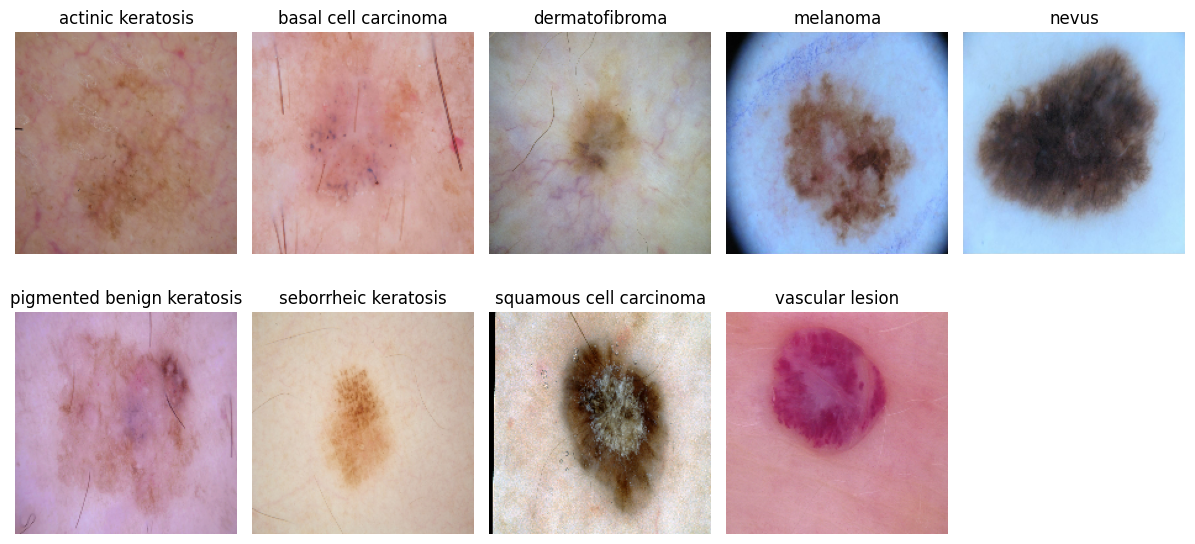

In [42]:
images_per_class = [None] * num_classes
# Iterate over the dataset
for images, labels in test_ds:
    for i, label in enumerate(labels.numpy()):
        if images_per_class[label] is None:
            images_per_class[label] = images[i].numpy()
        # Break if we've found an image for each class
        if all(img is not None for img in images_per_class):
            break
    if all(img is not None for img in images_per_class):
        break

# Plot the images
plt.figure(figsize=(12, 6))
for idx, image in enumerate(images_per_class):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(test_ds.class_names[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
#Updating the data augmentation parameters
#Select only vertical flip and increase zoom

data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.2),
    RandomZoom(0.3),
])

In [44]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      32,444,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,456,617 (123.81 MB)

 Trainable params: 32,456,233 (123.81 MB)

 Non-trainable params: 384 (1.50 KB)

In [46]:
#Run for 30 epochs
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 23s - 136ms/step - accuracy: 0.3162 - loss: 2.1766 - val_accuracy: 0.1151 - val_loss: 2.4750
Epoch 2/30
169/169 - 41s - 243ms/step - accuracy: 0.3876 - loss: 1.7406 - val_accuracy: 0.1477 - val_loss: 2.2257
Epoch 3/30
169/169 - 20s - 120ms/step - accuracy: 0.4114 - loss: 1.5959 - val_accuracy: 0.3170 - val_loss: 1.8668
Epoch 4/30
169/169 - 20s - 121ms/step - accuracy: 0.4442 - loss: 1.4671 - val_accuracy: 0.4439 - val_loss: 1.5015
Epoch 5/30
169/169 - 20s - 121ms/step - accuracy: 0.4570 - loss: 1.4225 - val_accuracy: 0.4388 - val_loss: 1.5254
Epoch 6/30
169/169 - 20s - 121ms/step - accuracy: 0.4842 - loss: 1.3735 - val_accuracy: 0.3259 - val_loss: 1.7938
Epoch 7/30
169/169 - 41s - 242ms/step - accuracy: 0.4931 - loss: 1.3299 - val_accuracy: 0.4833 - val_loss: 1.3833
Epoch 8/30
169/169 - 21s - 124ms/step - accuracy: 0.4946 - loss: 1.3105 - val_accuracy: 0.4506 - val_loss: 1.4208
Epoch 9/30
169/169 - 20s - 121ms/step - accuracy: 0.5087 - loss: 1.2825 - val_accuracy: 

In [47]:
make_predictions()

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Accuracy: 0.4322


**As the accuracy is still low, lets try with sgd optimizer instead of adam**

In [48]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      32,444,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,456,617 (123.81 MB)

 Trainable params: 32,456,233 (123.81 MB)

 Non-trainable params: 384 (1.50 KB)

In [49]:
#Run for 30 epochs
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 20s - 119ms/step - accuracy: 0.6018 - loss: 1.0474 - val_accuracy: 0.4714 - val_loss: 1.4513
Epoch 2/30
169/169 - 20s - 121ms/step - accuracy: 0.6146 - loss: 1.0211 - val_accuracy: 0.3252 - val_loss: 2.5435
Epoch 3/30
169/169 - 21s - 123ms/step - accuracy: 0.6263 - loss: 0.9821 - val_accuracy: 0.5301 - val_loss: 1.3359
Epoch 4/30
169/169 - 18s - 106ms/step - accuracy: 0.6304 - loss: 0.9697 - val_accuracy: 0.4543 - val_loss: 1.6308
Epoch 5/30
169/169 - 20s - 121ms/step - accuracy: 0.6296 - loss: 0.9792 - val_accuracy: 0.5523 - val_loss: 1.2722
Epoch 6/30
169/169 - 21s - 122ms/step - accuracy: 0.6174 - loss: 0.9913 - val_accuracy: 0.6563 - val_loss: 0.9204
Epoch 7/30
169/169 - 18s - 106ms/step - accuracy: 0.6295 - loss: 0.9767 - val_accuracy: 0.6169 - val_loss: 1.0012
Epoch 8/30
169/169 - 21s - 123ms/step - accuracy: 0.6348 - loss: 0.9744 - val_accuracy: 0.6585 - val_loss: 0.8992
Epoch 9/30
169/169 - 20s - 120ms/step - accuracy: 0.6409 - loss: 0.9660 - val_accuracy: 

In [50]:
make_predictions()

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Accuracy: 0.4237


Slight improvement in test accuracy but it is still low.

**Remove the augmentation layer and add L2 regularization for the overfitting**

In [51]:
from tensorflow.keras import regularizers

In [53]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

#model.add(data_augmentation) ## Added a layer of data augmentation
model.add(Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('softmax'))

In [54]:
### Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      32,444,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,456,617 (123.81 MB)

 Trainable params: 32,456,233 (123.81 MB)

 Non-trainable params: 384 (1.50 KB)

In [55]:
#Run for 30 epochs
epochs = 30
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs,
  verbose=2
)

Epoch 1/30
169/169 - 25s - 149ms/step - accuracy: 0.3440 - loss: 2.3806 - val_accuracy: 0.1203 - val_loss: 2.9813
Epoch 2/30
169/169 - 8s - 45ms/step - accuracy: 0.4777 - loss: 1.8207 - val_accuracy: 0.2517 - val_loss: 2.5175
Epoch 3/30
169/169 - 11s - 62ms/step - accuracy: 0.5527 - loss: 1.5705 - val_accuracy: 0.5687 - val_loss: 1.6025
Epoch 4/30
169/169 - 8s - 47ms/step - accuracy: 0.6343 - loss: 1.3509 - val_accuracy: 0.5449 - val_loss: 1.5735
Epoch 5/30
169/169 - 8s - 46ms/step - accuracy: 0.6877 - loss: 1.2130 - val_accuracy: 0.5575 - val_loss: 1.7066
Epoch 6/30
169/169 - 10s - 61ms/step - accuracy: 0.7209 - loss: 1.1249 - val_accuracy: 0.4321 - val_loss: 2.1536
Epoch 7/30
169/169 - 8s - 46ms/step - accuracy: 0.7927 - loss: 0.9112 - val_accuracy: 0.6674 - val_loss: 1.2561
Epoch 8/30
169/169 - 10s - 62ms/step - accuracy: 0.8390 - loss: 0.8064 - val_accuracy: 0.7832 - val_loss: 0.9799
Epoch 9/30
169/169 - 10s - 60ms/step - accuracy: 0.8667 - loss: 0.7310 - val_accuracy: 0.6897 - val

We have a comparatively improved train and validation accuracy

Lets make predictions with this model

In [56]:
make_predictions()

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Accuracy: 0.3475
